### EDA

In [473]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler, Normalizer, FunctionTransformer
from sklearn import metrics
from sklearn.pipeline import Pipeline, FeatureUnion

from keras.models import Sequential
from keras.layers import Convolution2D, Dense, Dropout, Activation, Flatten, MaxPool2D
from keras.utils import to_categorical
from keras.wrappers.scikit_learn import KerasClassifier

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [474]:
!ls ../assets

mapdata_copyright_openstreetmap_contributors.rds
mapdata_copyright_openstreetmap_contributors.txt
noaa_weather_qclcd_documentation.pdf
sampleSubmission.csv
spray.csv
test.csv
train.csv
weather.csv


In [475]:
df_train = pd.read_csv('../assets/train.csv')

In [476]:
df_train['Trap'].value_counts().head()

T900    750
T115    542
T138    314
T002    185
T135    183
Name: Trap, dtype: int64

In [477]:
df_test = pd.read_csv('../assets/test.csv')

In [478]:
df_spray = pd.read_csv('../assets/spray.csv')

In [479]:
df_weather = pd.read_csv('../assets/weather.csv')

In [480]:
df_train.shape, df_test.shape, df_spray.shape, df_weather.shape

((10506, 12), (116293, 11), (14835, 4), (2944, 22))

In [481]:
# drop irrelevant columns
train = df_train.drop(['Address', 'Block', 'Street', 'AddressNumberAndStreet', 'AddressAccuracy'], axis=1)

In [482]:
# baseline accuracy; it means that 95% accuracy just by answering '0' 
train['WnvPresent'].value_counts()[0]/train['WnvPresent'].value_counts().sum()

0.94755377879307068

In [483]:
test = df_test.drop(['Address', 'Block', 'Street', 'AddressNumberAndStreet', 'AddressAccuracy'], axis=1)

In [484]:
spray = df_spray.copy()

In [485]:
df_weather.columns

Index(['Station', 'Date', 'Tmax', 'Tmin', 'Tavg', 'Depart', 'DewPoint',
       'WetBulb', 'Heat', 'Cool', 'Sunrise', 'Sunset', 'CodeSum', 'Depth',
       'Water1', 'SnowFall', 'PrecipTotal', 'StnPressure', 'SeaLevel',
       'ResultSpeed', 'ResultDir', 'AvgSpeed'],
      dtype='object')

In [486]:
weather  = df_weather.drop(['Sunrise', 'Sunset', 'CodeSum', 'Depth', 'Water1', 'SnowFall'], axis=1)

In [487]:
weather.loc[2743, 'SeaLevel']

'M'

In [488]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2944 entries, 0 to 2943
Data columns (total 16 columns):
Station        2944 non-null int64
Date           2944 non-null object
Tmax           2944 non-null int64
Tmin           2944 non-null int64
Tavg           2944 non-null object
Depart         2944 non-null object
DewPoint       2944 non-null int64
WetBulb        2944 non-null object
Heat           2944 non-null object
Cool           2944 non-null object
PrecipTotal    2944 non-null object
StnPressure    2944 non-null object
SeaLevel       2944 non-null object
ResultSpeed    2944 non-null float64
ResultDir      2944 non-null int64
AvgSpeed       2944 non-null object
dtypes: float64(1), int64(5), object(10)
memory usage: 368.1+ KB


In [489]:
weather.head(10)

,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
0,1,2007-05-01,83,50,67,14,51,56,0,2,0.00,29.10,29.82,1.7,27,9.2
1,2,2007-05-01,84,52,68,M,51,57,0,3,0.00,29.18,29.82,2.7,25,9.6
2,1,2007-05-02,59,42,51,-3,42,47,14,0,0.00,29.38,30.09,13.0,4,13.4
3,2,2007-05-02,60,43,52,M,42,47,13,0,0.00,29.44,30.08,13.3,2,13.4
4,1,2007-05-03,66,46,56,2,40,48,9,0,0.00,29.39,30.12,11.7,7,11.9
5,2,2007-05-03,67,48,58,M,40,50,7,0,0.00,29.46,30.12,12.9,6,13.2
6,1,2007-05-04,66,49,58,4,41,50,7,0,T,29.31,30.05,10.4,8,10.8
7,2,2007-05-04,78,51,M,M,42,50,M,M,0.00,29.36,30.04,10.1,7,10.4
8,1,2007-05-05,66,53,60,5,38,49,5,0,T,29.40,30.10,11.7,7,12.0
9,2,2007-05-05,66,54,60,M,39,50,5,0,T,29.46,30.09,11.2,7,11.5


In [490]:
weather.shape

(2944, 16)

In [491]:
weather['Date'] = pd.to_datetime(weather['Date'])

In [492]:
def count_Ms_Ts(df):
    print('{0:13s} {1:>5s} {2:>5s} {3:>8s} {4:>8s}'.format('column', 'Ms', 'Ts', 'Others', 'Total'))
    for col in df.columns:
        cnt_M = 0
        cnt_T = 0
        cnt_O = 0
        for i, row in df.iterrows():
            if row[col] == 'M':
                cnt_M += 1
###                print('(M) index=',i)
            elif row[col] == '  T':
                cnt_T += 1
###                print('(T) index=',i)
            else:
                if col != 'Date':
                    cnt_O += 1
                    try:
                        float(row[col])
                    except ValueError:
                        print('ERROR:', i, row['Station'], row[col])
        print('{0:13s} {1:5.0f} {2:5.0f} {3:8.0f} {4:8.0f}'.format(col, cnt_M, cnt_T, cnt_O, cnt_M+cnt_T+cnt_O))

In [493]:
count_Ms_Ts(weather)

column           Ms    Ts   Others    Total
Station           0     0     2944     2944
Date              0     0        0        0
Tmax              0     0     2944     2944
Tmin              0     0     2944     2944
Tavg             11     0     2933     2944
Depart         1472     0     1472     2944
DewPoint          0     0     2944     2944
WetBulb           4     0     2940     2944
Heat             11     0     2933     2944
Cool             11     0     2933     2944
PrecipTotal       2   318     2624     2944
StnPressure       4     0     2940     2944
SeaLevel          9     0     2935     2944
ResultSpeed       0     0     2944     2944
ResultDir         0     0     2944     2944
AvgSpeed          3     0     2941     2944


In [494]:
# The 11 M's are Tavg, Heat, and Cool are all in the same rows.  It is better to drop all of them than replacing them
# by speculative values.
Tavg_Ms = weather[ weather['Tavg']=='M' ].index.tolist()
weather.drop(index=Tavg_Ms, axis=0, inplace=True)

In [495]:
Tavg_Ms

[7, 505, 675, 1637, 2067, 2211, 2501, 2511, 2525, 2579, 2811]

In [496]:
# The 2 M's in PrecipTotal are from Station 2 and can be replaced by the values in Station 1 of the same days.
weather[ weather['PrecipTotal']=='M' ]

,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
117,2,2007-06-28,73,61,67,M,56,61,0,2,M,29.43,30.07,12.2,2,13.3
119,2,2007-06-29,71,56,64,M,56,60,1,0,M,29.47,30.11,7.4,2,8.2


In [497]:
weather.loc[117, 'PrecipTotal'] = weather.loc[116, 'PrecipTotal']
weather.loc[119, 'PrecipTotal'] = weather.loc[118, 'PrecipTotal']

In [498]:
# 4 M's in WetBulb of one station should be manually replaced by the values of the other station of the same day.
weather[ weather['WetBulb']=='M' ]

,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
848,1,2009-06-26,86,69,78,7,60,M,0,13,0.00,M,29.85,6.4,4,8.2
2410,1,2013-08-10,81,64,73,0,57,M,0,8,0.00,M,30.08,5.3,5,6.5
2412,1,2013-08-11,81,60,71,-2,61,M,0,6,0.01,29.35,30.07,2.0,27,3.0
2415,2,2013-08-12,85,69,77,M,63,M,0,12,0.66,29.27,29.92,4.5,26,7.7


In [499]:
weather.loc[848, 'WetBulb'] = weather.loc[849, 'WetBulb']
weather.loc[2410, 'WetBulb'] = weather.loc[2411, 'WetBulb']
weather.loc[2412, 'WetBulb'] = weather.loc[2413, 'WetBulb']
weather.loc[2415, 'WetBulb'] = weather.loc[2414, 'WetBulb']

In [500]:
# The first 2 M's in StnPressure in one station should also be manually replaced by the values of the other station
# of the same day.  The other 2 M's are in the same day, so we can simply drop those rows.
weather[ weather['StnPressure']=='M' ]

,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
87,2,2007-06-13,86,68,77,M,53,62,0,12,0.00,M,M,7.0,5,M
848,1,2009-06-26,86,69,78,7,60,67,0,13,0.00,M,29.85,6.4,4,8.2
2410,1,2013-08-10,81,64,73,0,57,63,0,8,0.00,M,30.08,5.3,5,6.5
2411,2,2013-08-10,81,68,75,M,55,63,0,10,0.00,M,30.07,6.0,6,7.4


In [501]:
weather.loc[87, 'StnPressure'] = weather.loc[86, 'StnPressure']
weather.loc[848, 'StnPressure'] = weather.loc[849, 'StnPressure']
weather.drop(index=[2410, 2411], inplace=True)

In [502]:
# Replace 318 T's in PrecipTotal by 0.00.
weather['PrecipTotal'] = weather['PrecipTotal'].str.strip().replace('T','0')

In [503]:
# It is better to drop the 9 M's in SeaLevel than replacing them by speculative values.
SeaLevel_Ms = weather[ weather['SeaLevel']=='M' ].index.tolist()
weather.drop(index=SeaLevel_Ms, axis=0, inplace=True)

In [504]:
# It is better to drop the 3 M's in AvgSpeed than replacing them by speculative values.
AvgSpeed_Ms = weather[ (weather['AvgSpeed']=='M') | (weather['AvgSpeed'].isna()) ].index.tolist()
weather.drop(index=AvgSpeed_Ms, axis=0, inplace=True)

In [505]:
# 1472 M's in Depart appears only in Station 2, so simply drop them.
Depart_Ms = weather[ (weather['Depart']=='M') ].index.tolist()
weather.drop(index=Depart_Ms, axis=0, inplace=True)

In [506]:
count_Ms_Ts(weather)

column           Ms    Ts   Others    Total
Station           0     0     1466     1466
Date              0     0        0        0
Tmax              0     0     1466     1466
Tmin              0     0     1466     1466
Tavg              0     0     1466     1466
Depart            0     0     1466     1466
DewPoint          0     0     1466     1466
WetBulb           0     0     1466     1466
Heat              0     0     1466     1466
Cool              0     0     1466     1466
PrecipTotal       0     0     1466     1466
StnPressure       0     0     1466     1466
SeaLevel          0     0     1466     1466
ResultSpeed       0     0     1466     1466
ResultDir         0     0     1466     1466
AvgSpeed          0     0     1466     1466


In [507]:
weather.isnull().sum()

Station        0
Date           0
Tmax           0
Tmin           0
Tavg           0
Depart         0
DewPoint       0
WetBulb        0
Heat           0
Cool           0
PrecipTotal    0
StnPressure    0
SeaLevel       0
ResultSpeed    0
ResultDir      0
AvgSpeed       0
dtype: int64

In [459]:
weather.dtypes

Station                 int64
Date           datetime64[ns]
Tmax                    int64
Tmin                    int64
Tavg                   object
Depart                 object
DewPoint                int64
WetBulb                object
Heat                   object
Cool                   object
PrecipTotal            object
StnPressure            object
SeaLevel               object
ResultSpeed           float64
ResultDir               int64
AvgSpeed               object
dtype: object

In [508]:
# List of Column Headers
weather_columns = weather.columns.tolist()
print(weather_columns)
print(len(weather_columns))

['Station', 'Date', 'Tmax', 'Tmin', 'Tavg', 'Depart', 'DewPoint', 'WetBulb', 'Heat', 'Cool', 'PrecipTotal', 'StnPressure', 'SeaLevel', 'ResultSpeed', 'ResultDir', 'AvgSpeed']
16


In [509]:
#weather_avg = weather.groupby('Date')[weather_columns[3:]].mean().reset_index(level=0)

In [510]:
#weather_avg.tail()

In [511]:
flts = ['PrecipTotal', 'ResultSpeed', 'AvgSpeed','StnPressure', 'SeaLevel']
ints = ['Tavg', 'WetBulb','Heat','Cool','ResultDir','Depart']

In [512]:
# Convert objects to integers
weather[ints] = weather[ints].astype('int')
# Convert objects to floats
weather[flts] = weather[flts].astype('float')

In [513]:
# Farenheit to Celcius for RH calculation
weather[['Tavg(C)','DewPoint(C)','WetBulb(C)']]=weather[['Tavg','DewPoint','WetBulb']].apply(lambda x: (x-32)*(5/9)).round(1)

In [514]:
#Calculation Relative Humidity
weather['RH'] = ((np.exp(17.67*weather['DewPoint(C)']/(243.5+weather['DewPoint(C)'])))*100 /
                 (np.exp((17.67*weather['Tavg(C)']/(243.5+weather['Tavg(C)']))))).round(1)
#weather['RH2'] = ((6.112*np.exp(17.502*weather['WetBulb(C)']/(240.97+weather['WetBulb(C)']))
#                   -0.6687451584*(1.0+0.00115*weather['WetBulb(C)'])*(weather['DewPoint(C)']-weather['WetBulb(C)']))*100 / 
#                 (6.112*np.exp(17.502*weather['DewPoint(C)']/(240.97+weather['DewPoint(C)'])))).round(1)

In [516]:
weather.head()

,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed,Tavg(C),DewPoint(C),WetBulb(C),RH
0,1,2007-05-01,83,50,67,14,51,56,0,2,0.0,29.10,29.82,1.7,27,9.2,19.4,10.6,13.3,56.7
2,1,2007-05-02,59,42,51,-3,42,47,14,0,0.0,29.38,30.09,13.0,4,13.4,10.6,5.6,8.3,71.2
4,1,2007-05-03,66,46,56,2,40,48,9,0,0.0,29.39,30.12,11.7,7,11.9,13.3,4.4,8.9,54.8
6,1,2007-05-04,66,49,58,4,41,50,7,0,0.0,29.31,30.05,10.4,8,10.8,14.4,5.0,10.0,53.2
8,1,2007-05-05,66,53,60,5,38,49,5,0,0.0,29.40,30.10,11.7,7,12.0,15.6,3.3,9.4,43.7


In [517]:
weather.shape

(1466, 20)

In [518]:
weather.columns

Index(['Station', 'Date', 'Tmax', 'Tmin', 'Tavg', 'Depart', 'DewPoint',
       'WetBulb', 'Heat', 'Cool', 'PrecipTotal', 'StnPressure', 'SeaLevel',
       'ResultSpeed', 'ResultDir', 'AvgSpeed', 'Tavg(C)', 'DewPoint(C)',
       'WetBulb(C)', 'RH'],
      dtype='object')

In [523]:
weather.drop(labels=['Tavg(C)', 'DewPoint(C)', 'WetBulb(C)'], axis=1, inplace=True)

In [524]:
weather.shape

(1466, 17)

In [527]:
weather.columns

Index(['Station', 'Date', 'Tmax', 'Tmin', 'Tavg', 'Depart', 'DewPoint',
       'WetBulb', 'Heat', 'Cool', 'PrecipTotal', 'StnPressure', 'SeaLevel',
       'ResultSpeed', 'ResultDir', 'AvgSpeed', 'RH'],
      dtype='object')

In [528]:
weather.columns.tolist()[2:18]

['Tmax',
 'Tmin',
 'Tavg',
 'Depart',
 'DewPoint',
 'WetBulb',
 'Heat',
 'Cool',
 'PrecipTotal',
 'StnPressure',
 'SeaLevel',
 'ResultSpeed',
 'ResultDir',
 'AvgSpeed',
 'RH']

In [529]:
columns_groupby = weather.columns.tolist()[2:18]
print(columns_groupby)

['Tmax', 'Tmin', 'Tavg', 'Depart', 'DewPoint', 'WetBulb', 'Heat', 'Cool', 'PrecipTotal', 'StnPressure', 'SeaLevel', 'ResultSpeed', 'ResultDir', 'AvgSpeed', 'RH']


In [531]:
weather.shape

(1466, 17)

In [532]:
weather = weather.groupby('Date')[columns_groupby].mean().reset_index(level=0)

In [533]:
# Shape of weather _new is larger than the shape of station 
weather.shape

(1466, 16)

In [534]:
weather.isnull().sum()

Date           0
Tmax           0
Tmin           0
Tavg           0
Depart         0
DewPoint       0
WetBulb        0
Heat           0
Cool           0
PrecipTotal    0
StnPressure    0
SeaLevel       0
ResultSpeed    0
ResultDir      0
AvgSpeed       0
RH             0
dtype: int64

In [535]:
weather.head()

,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed,RH
0,2007-05-01,83,50,67,14,51,56,0,2,0.0,29.10,29.82,1.7,27,9.2,56.7
1,2007-05-02,59,42,51,-3,42,47,14,0,0.0,29.38,30.09,13.0,4,13.4,71.2
2,2007-05-03,66,46,56,2,40,48,9,0,0.0,29.39,30.12,11.7,7,11.9,54.8
3,2007-05-04,66,49,58,4,41,50,7,0,0.0,29.31,30.05,10.4,8,10.8,53.2
4,2007-05-05,66,53,60,5,38,49,5,0,0.0,29.40,30.10,11.7,7,12.0,43.7


In [536]:
!pwd

/Users/Lee/GA/projects/project-4/west_nile/working


In [537]:
# create a csv file
weather.to_csv(path_or_buf='./weather.csv')

#### Feature engineering

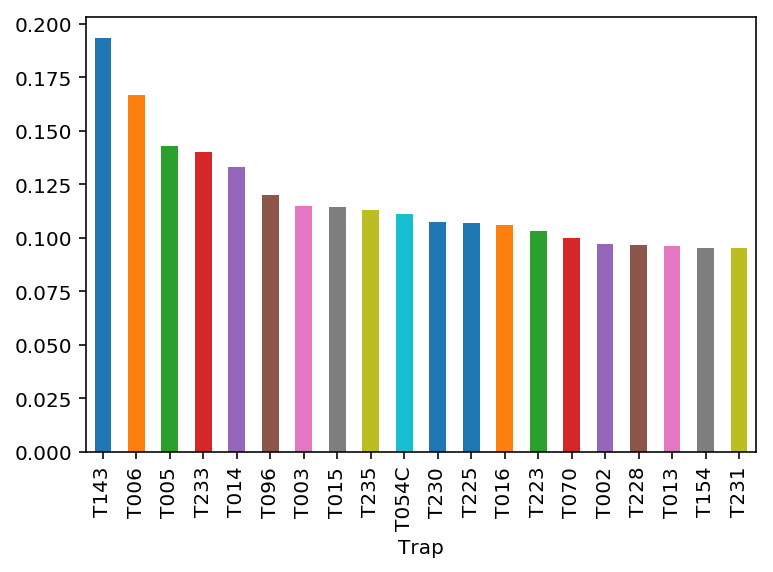

In [100]:
df_train.groupby('Trap')['WnvPresent'].mean().sort_values(ascending=False).head(20).plot.bar()

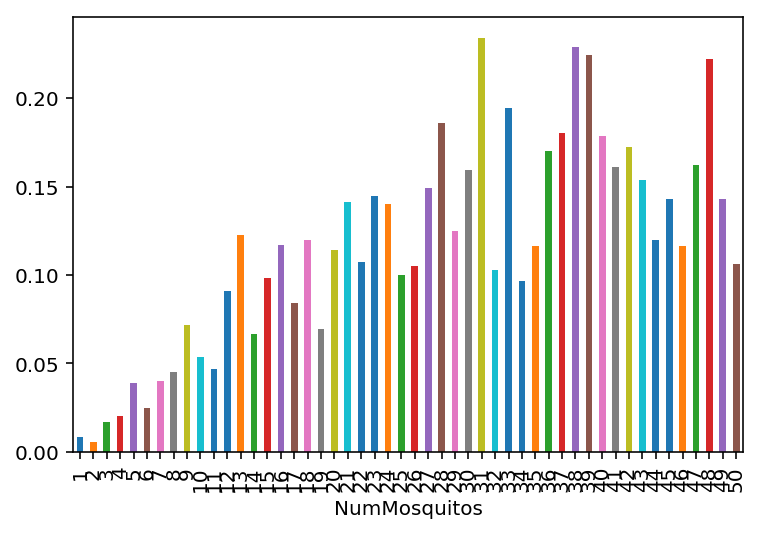

In [104]:
df_train.groupby(['NumMosquitos'])['WnvPresent'].mean().plot.bar()

In [77]:
df_train['Species'].value_counts()

CULEX PIPIENS/RESTUANS    4752
CULEX RESTUANS            2740
CULEX PIPIENS             2699
CULEX TERRITANS            222
CULEX SALINARIUS            86
CULEX TARSALIS               6
CULEX ERRATICUS              1
Name: Species, dtype: int64

In [78]:
df_test['Species'].value_counts()

CULEX PIPIENS/RESTUANS    15359
CULEX RESTUANS            14670
CULEX PIPIENS             14521
CULEX SALINARIUS          14355
CULEX TERRITANS           14351
CULEX TARSALIS            14347
CULEX ERRATICUS           14345
UNSPECIFIED CULEX         14345
Name: Species, dtype: int64